In [2]:
from pycaret.regression import *
import pandas as pd
import matplotlib.pyplot as plt
from functions import accuracy
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [3]:
df_raw = pd.read_csv('kunak_filled.csv', parse_dates=[0], index_col=0)
df=df_raw.asfreq('H')

In [4]:
week = 24*7
month = week*4
step = 0
errors = {}

In [5]:
while step<=(df.shape[0]//week):
    
    date_from = step*week
    date_to = month + date_from
    
    if (date_to+24) > df.shape[0]:
        print('Complete')
        break
        
    sample = df[date_from : date_to].copy()
    
    target = 'NO2 (ppb)'
    steps = int(sample.shape[0]*0.1)
    
    train = sample[:-steps]
    test = sample[-steps:]
    
    numeric_features = df.columns.drop(target).to_list()
    
    s = setup(data=train, test_data=test, target=target, fold_strategy='timeseries',
          numeric_features=numeric_features,
          fold=3,silent=True, session_id=123, verbose=0)
    
    model = create_model('rf', verbose=False)
    predictions = predict_model(model, data=test[-24:], verbose=False)
    
    errors_list = [mean_absolute_error(predictions[target], predictions.Label),
               mean_squared_error(predictions[target], predictions.Label),
              accuracy(predictions[target], predictions.Label)['mape'],
              r2_score(predictions[target], predictions.Label)]
    
    
        
    errors[str(df.index[date_to+24].date())] = errors_list
    step += 1

IndexError: index 3552 is out of bounds for axis 0 with size 3552

In [6]:
errors_df = pd.DataFrame(errors).T
errors_df.columns=['MAE', 'MSE', 'MAPE', 'R2']
errors_df.index = pd.to_datetime(errors_df.index)
errors_df

,MAE,MSE,MAPE,R2
2022-05-09,0.998721,1.400794,0.019,0.986109
2022-05-16,4.323429,56.373420,0.081,0.685418
2022-05-23,3.041946,18.246970,0.076,0.875362
2022-05-30,4.546058,29.849157,0.087,0.710242
2022-06-06,1.211850,2.027644,0.029,0.974636
2022-06-13,1.861409,5.579424,0.028,0.964700
2022-06-20,0.821608,1.147353,0.012,0.988038
2022-06-27,1.603054,4.720434,0.033,0.959798
2022-07-04,0.733079,1.028628,0.016,0.989014
2022-07-11,5.439854,38.152441,0.076,0.086714


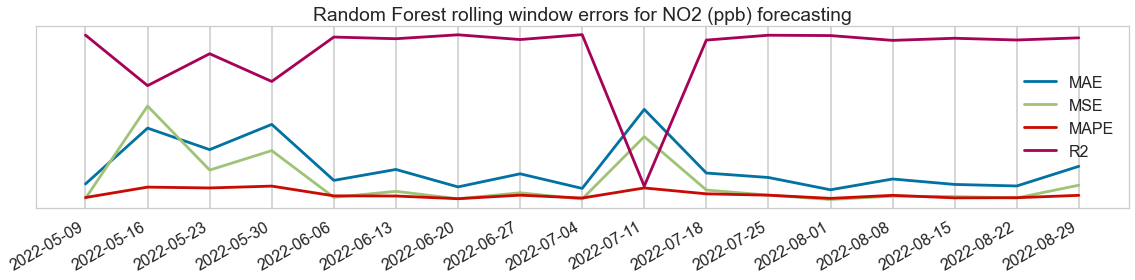

In [9]:
plt.style.use('seaborn-poster')
errors_df_scaled = errors_df.copy()
errors_df_scaled.iloc[:,1] = errors_df_scaled['MSE']/10
errors_df_scaled.iloc[:,2] = errors_df_scaled['MAPE']*10
errors_df_scaled.iloc[:,3] = errors_df_scaled['R2']*10
errors_df_scaled.plot(figsize=(16,4), x_compat=True)
plt.yticks([])
plt.xticks(errors_df.index)
plt.title(f"Random Forest rolling window errors for {target} forecasting")
plt.tight_layout()
plt.savefig(f"Plots/rf/{target}rolling_error.png")
plt.show()